In [1]:
import numpy as np
import cv2
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Define paths to your dataset
dataset_path = 'D:/DATASET/CNN/ballooning/train'

# Define the subdirectories for each class
class_names = ['0', '1']

# Initialize lists to store images and labels
images = []
labels = []

In [2]:
# Loop through each class directory
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    
    # Loop through each image in the class directory
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        
        # Read and preprocess the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error: Unable to load image at path: {image_path}")
            continue  # Skip to the next image
        if image.size == 0:
            print(f"Error: Empty image at path: {image_path}")
            continue  # Skip to the next image
        image = cv2.resize(image, (224, 224))
        image = np.expand_dims(image, axis=-1)  # Add channel dimension
        images.append(image)
        
        # Assign the label based on the class directory
        label = int(class_name)
        labels.append(label)

Error: Unable to load image at path: D:/DATASET/CNN/ballooning/train\0\Thumbs.db
Error: Unable to load image at path: D:/DATASET/CNN/ballooning/train\1\Thumbs.db


In [3]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Print the shapes of the images and labels arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (27698, 224, 224, 1)
Labels shape: (27698,)


In [4]:
# X: images, y: labels
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255
)

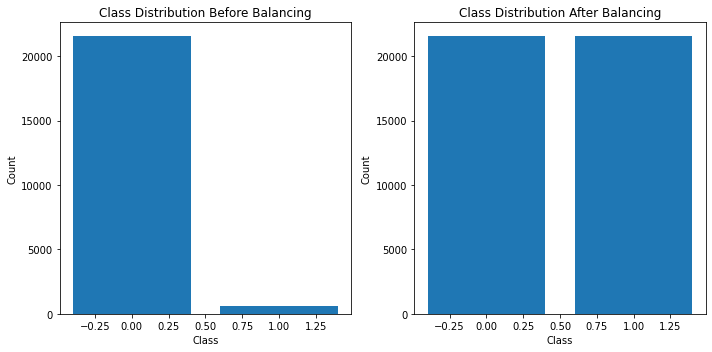

In [5]:
import matplotlib.pyplot as plt

# Visualize class distribution before balancing
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(np.unique(y_train), np.bincount(y_train))
plt.title('Class Distribution Before Balancing')
plt.xlabel('Class')
plt.ylabel('Count')

# Implement data balancing technique (oversampling of minority class)
from imblearn.over_sampling import RandomOverSampler

# Reshape X_train and X_test to remove the channel dimension
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

# Apply oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_reshaped, y_train)

# Reshape X_train_balanced back to original shape
X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], X_train.shape[1], X_train.shape[2])

# Train your model using X_train_balanced and y_train_balanced

# Visualize class distribution after balancing
plt.subplot(1, 2, 2)
plt.bar(np.unique(y_train_balanced), np.bincount(y_train_balanced))
plt.title('Class Distribution After Balancing')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Reshape X_test to remove the channel dimension
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])


In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for preprocessing images
image_data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255
)

# Define the directories for training and validation data
train_dir = 'D:/DATASET/CNN/ballooning/train'
validation_dir = 'D:/DATASET/CNN/ballooning/val'

# Prepare iterators for training and validation data
train_iterator = image_data_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_iterator = image_data_generator.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Define the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a flattening layer and a fully connected layer to the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

Found 27698 images belonging to 2 classes.
Found 27698 images belonging to 2 classes.


In [7]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_iterator, epochs=5, validation_data=validation_iterator)


# Compile the model
#model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
#history = model.fit(X_train_balanced, y_train_balanced, batch_size=32, epochs=5, validation_data=(X_test_reshaped, y_test))

Epoch 1/5
866/866 [==============================] - 12121s 14s/step - loss: 0.3282 - accuracy: 0.9705 - val_loss: 0.3466 - val_accuracy: 0.9719
Epoch 2/5
866/866 [==============================] - 10079s 12s/step - loss: 0.2857 - accuracy: 0.9713 - val_loss: 0.0948 - val_accuracy: 0.9719
Epoch 3/5
866/866 [==============================] - 10095s 12s/step - loss: 0.0907 - accuracy: 0.9719 - val_loss: 0.0898 - val_accuracy: 0.9719
Epoch 4/5
866/866 [==============================] - 11795s 14s/step - loss: 0.0974 - accuracy: 0.9719 - val_loss: 0.0874 - val_accuracy: 0.9719
Epoch 5/5
866/866 [==============================] - 13564s 16s/step - loss: 0.0862 - accuracy: 0.9719 - val_loss: 0.0805 - val_accuracy: 0.9719


In [10]:
from skimage import color

# Convert grayscale images to RGB format
X_test_rgb = np.array([color.gray2rgb(img) for img in X_test_reshaped])

# Reshape X_test_rgb to the original image shape
X_test_original_shape = X_test_rgb.reshape(-1, 224, 224, 3)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_original_shape, y_test)
print("Test Accuracy:", test_acc)

# Save the model
model.save('D:/DATASET/Models/model_ballooning.h5')

174/174 [==============================] - 283s 2s/step - loss: 2600.2996 - accuracy: 0.9708
Test Accuracy: 0.9707581400871277


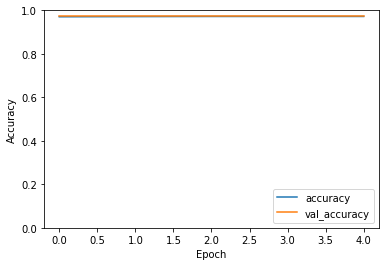

In [11]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

1/1 [==============================] - 1s 1s/step
Predicted NASH score: 0: Ballooning absent
1/1 [==============================] - 0s 102ms/step


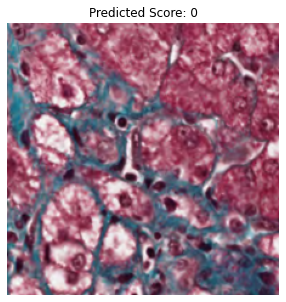

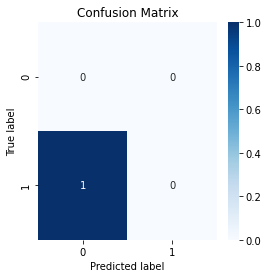

C:\Users\JUHI\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


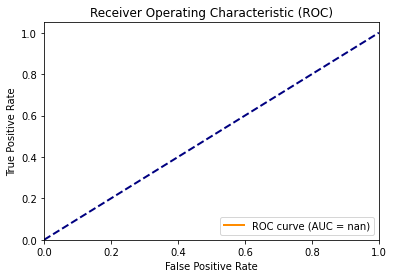

In [8]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import load_model
from skimage import color
from tensorflow.keras.applications.resnet50 import preprocess_input  # Import preprocess_input function


def predict_image(image_path, model):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image_resized = cv2.resize(image_rgb, (224, 224))
    image_preprocessed = np.expand_dims(image_resized, axis=0) / 255.0

    # Predict the score
    prediction = model.predict(image_preprocessed)
    predicted_score = np.argmax(prediction)

    # Define the NASH score mapping
    nash_scores = {
        0: "0: Ballooning absent",
        1: "1: Ballooning present"
    }
    
    # Get the NASH score corresponding to the maximum probability
    nash_score = nash_scores[predicted_score]
    
    # Print the NASH score
    print('Predicted NASH score:', nash_score)
    
    return predicted_score

def plot_evaluation(image_path, model):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image_resized = cv2.resize(image_rgb, (224, 224))
    image_preprocessed = np.expand_dims(image_resized, axis=0) / 255.0

    # Predict the score
    prediction = model.predict(image_preprocessed)
    predicted_score = np.argmax(prediction)

    # Plot sample predictions
    plt.figure(figsize=(5, 5))
    plt.imshow(image_resized)
    plt.title(f"Predicted Score: {predicted_score}")
    plt.axis('off')
    plt.show()

    # Confusion matrix
    y_true = [1]  # Assuming class 1 as the true label
    predicted_classes = [predicted_score]
    conf_matrix = confusion_matrix(y_true, predicted_classes)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, predicted_classes)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Load the model
model = load_model('D:/DATASET/Models/model_ballooning.h5')

# Take input image path from the user
image_path = "D:/DATASET/CNN/ballooning/train/1/10_116_90.png"

# Plot graphs for the input image
predicted_score = predict_image(image_path, model)
plot_evaluation(image_path, model)


1/1 [==============================] - 2s 2s/step
Predicted NASH score: 0: Ballooning absent
1/1 [==============================] - 0s 196ms/step


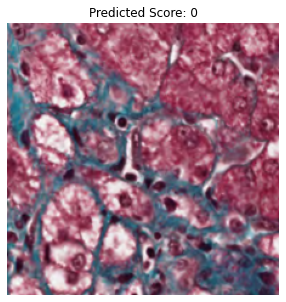

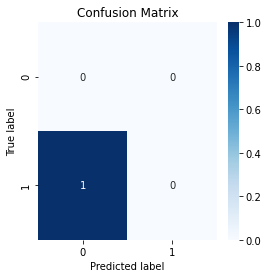

C:\Users\JUHI\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


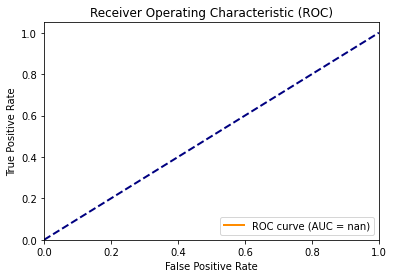

In [6]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import load_model
from skimage import color

def predict_image(image_path, model):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image_resized = cv2.resize(image_rgb, (224, 224))
    image_preprocessed = np.expand_dims(image_resized, axis=0) / 255.0

    # Predict the score
    prediction = model.predict(image_preprocessed)
    predicted_score = np.argmax(prediction)

    # Define the NASH score mapping
    nash_scores = {
        0: "0: Ballooning absent",
        1: "1: Ballooning present"
    }
    
    # Get the NASH score corresponding to the maximum probability
    nash_score = nash_scores[predicted_score]
    
    # Print the NASH score
    print('Predicted NASH score:', nash_score)
    
    return predicted_score

def plot_evaluation(image_path, model):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image_resized = cv2.resize(image_rgb, (224, 224))
    image_preprocessed = np.expand_dims(image_resized, axis=0) / 255.0

    # Predict the score
    prediction = model.predict(image_preprocessed)
    predicted_score = np.argmax(prediction)

    # Plot sample predictions
    plt.figure(figsize=(5, 5))
    plt.imshow(image_resized)
    plt.title(f"Predicted Score: {predicted_score}")
    plt.axis('off')
    plt.show()

    # Confusion matrix
    y_true = [1]  # Assuming class 1 as the true label
    predicted_classes = [predicted_score]
    conf_matrix = confusion_matrix(y_true, predicted_classes)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, predicted_classes)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Load the model
model = load_model('D:/DATASET/Models/model_ballooning.h5')

# Take input image path from the user
image_path = "D:/DATASET/CNN/ballooning/train/1/10_116_90.png"

# Plot graphs for the input image
predicted_score = predict_image(image_path, model)
plot_evaluation(image_path, model)

In [4]:
# Plot evaluation graphs for the input image
def plot_evaluation(image_path, model):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image_resized = cv2.resize(image_rgb, (224, 224))
    image_preprocessed = np.expand_dims(image_resized, axis=0) / 255.0

    # Predict the score
    prediction = model.predict(image_preprocessed)
    predicted_score = np.argmax(prediction)

    # Plot sample predictions
    plt.figure(figsize=(5, 5))
    plt.imshow(image_resized)
    plt.title(f"Predicted Score: {predicted_score}")
    plt.axis('off')
    plt.show()

    # Confusion matrix
    y_true = [0]  # As we are plotting for only one image
    predicted_classes = [predicted_score]
    conf_matrix = confusion_matrix(y_true, predicted_classes)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, predicted_classes)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

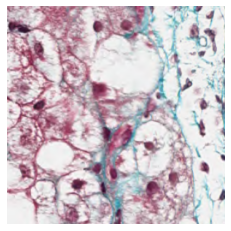

1/1 [==============================] - 2s 2s/step
Predictions:  [[0.3624423]]
Predicted NASH score: 0: Ballooning absent
1/1 [==============================] - 0s 201ms/step


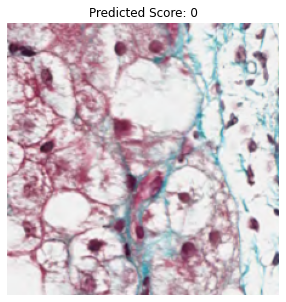

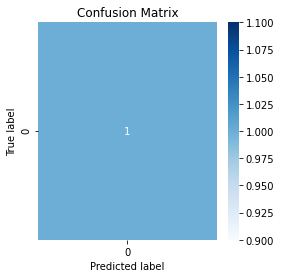

C:\Users\JUHI\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


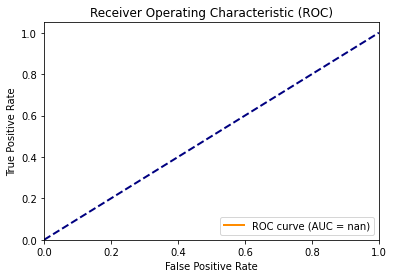

In [5]:
# Take input image path from the user
image_path = "D:/DATASET/CNN/ballooning/train/1/8_303_49.png"

# Plot graphs for the input image
show_image(image_path)
predict_image(image_path, model)
plot_evaluation(image_path, model)